In [1]:
import numpy as np
import pandas as pd
from darts.metrics.metrics import r2_score, smape, mae, mape
from darts.dataprocessing.transformers.scaler import Scaler
from darts.utils.missing_values import fill_missing_values
#from darts.models import RNNModel, LightGBMModel
from darts.timeseries import TimeSeries

In [2]:
raw_data = pd.read_csv('site_id_1.csv', parse_dates=['timestamp'])

In [3]:
raw_data.head()

,timestamp,meter_reading,air_temperature,cloud_coverage,dew_temperature,sea_level_pressure,wind_direction,wind_speed
0,2016-01-01 00:00:00,4154.2543,3.8,NaN,2.4,1020.9,240.0,3.1
1,2016-01-01 01:00:00,8337.2696,3.7,0.0,2.4,1021.6,230.0,2.6
2,2016-01-01 02:00:00,8317.9158,2.6,0.0,1.9,1021.9,0.0,0.0
3,2016-01-01 03:00:00,8392.4680,2.0,0.0,1.2,1022.3,170.0,1.5
4,2016-01-01 04:00:00,8109.9117,2.3,0.0,1.8,1022.7,110.0,1.5


In [4]:
#Check for missing timesteps
def is_missing_timesteps(df, date_col = 'date', freq='1H'):
    index_series  = pd.date_range(start=df[date_col][df.index[0]], end=df[date_col][df.index[-1]], freq=freq)
    return not index_series.equals(pd.Index(pd.to_datetime(df[date_col])))

In [5]:
is_missing_timesteps(raw_data, date_col='timestamp')

False

In [6]:
#So, the dataframe is missing some datetime steps, Let's extract missing timesteps
def get_missing_timesteps(df, date_col ='date', freq='H'):
    index_series = pd.date_range(start=df[date_col][df.index[0]], end=df[date_col][df.index[-1]], freq=freq)
    df_index = pd.Index(pd.to_datetime(df[date_col]))
    return index_series.difference(df_index)

In [7]:
get_missing_timesteps(raw_data, date_col='timestamp')

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [8]:
raw_data.head()

,timestamp,meter_reading,air_temperature,cloud_coverage,dew_temperature,sea_level_pressure,wind_direction,wind_speed
0,2016-01-01 00:00:00,4154.2543,3.8,NaN,2.4,1020.9,240.0,3.1
1,2016-01-01 01:00:00,8337.2696,3.7,0.0,2.4,1021.6,230.0,2.6
2,2016-01-01 02:00:00,8317.9158,2.6,0.0,1.9,1021.9,0.0,0.0
3,2016-01-01 03:00:00,8392.4680,2.0,0.0,1.2,1022.3,170.0,1.5
4,2016-01-01 04:00:00,8109.9117,2.3,0.0,1.8,1022.7,110.0,1.5


In [9]:
raw_data.isnull().mean()

timestamp             0.000000
meter_reading         0.000000
air_temperature       0.002505
cloud_coverage        0.806352
dew_temperature       0.002505
sea_level_pressure    0.008311
wind_direction        0.002732
wind_speed            0.002391
dtype: float64

In [10]:
raw_data['air_temperature'] = raw_data['air_temperature'].interpolate()
raw_data['cloud_coverage'] = raw_data['cloud_coverage'].fillna(-1)
raw_data['dew_temperature'] = raw_data['dew_temperature'].interpolate()
raw_data['sea_level_pressure'] = raw_data['sea_level_pressure'].interpolate()
raw_data['wind_direction'] = raw_data['wind_direction'].interpolate()
raw_data['wind_speed'] = raw_data['wind_speed'].interpolate()

In [11]:
raw_data.isnull().mean()

timestamp             0.0
meter_reading         0.0
air_temperature       0.0
cloud_coverage        0.0
dew_temperature       0.0
sea_level_pressure    0.0
wind_direction        0.0
wind_speed            0.0
dtype: float64

In [12]:
time_col = 'timestamp'
value_cols = list(raw_data.columns.drop('timestamp'))

In [13]:
ts_data = TimeSeries.from_dataframe(raw_data, time_col='timestamp', value_cols=value_cols)
#ts_data = ts_data[0:1000]

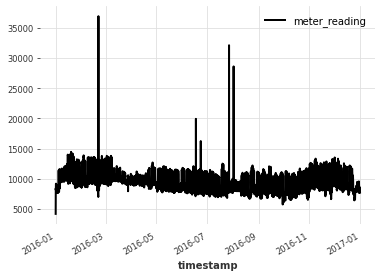

In [14]:
ts_data['meter_reading'].plot()

In [15]:
target_col = ['meter_reading']

cov_cols = list(ts_data.columns.drop(target_col))

In [16]:
train, test = ts_data.split_after(0.85)

train_target = train[target_col]
train_cov = train[cov_cols]

test_target = test[target_col]
test_cov = test[cov_cols]

In [17]:
#Scaling training and testing data
target_scaler = Scaler()
cov_scaler = Scaler()

train_target = target_scaler.fit_transform(train_target)
test_target = target_scaler.transform(test_target)

train_cov = cov_scaler.fit_transform(train_cov)
test_cov = cov_scaler.transform(test_cov)


In [18]:
rnn_model = RNNModel(
    model='RNN',
    output_chunk_length=24,
    input_chunk_length=24*14,
    training_length=24*30,
    hidden_dim=30,
    n_rnn_layers=4,
    n_epochs=50,
    dropout=0.08,
    random_state=10
)

NameError: name 'RNNModel' is not defined

In [96]:
rnn_model.fit(train_target, future_covariates=train_cov.append(test_cov), verbose=True)

[2021-12-04 18:02:11,693] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 6746 samples.
[2021-12-04 18:02:11,693] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 6746 samples.
[2021-12-04 18:02:11,696] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-12-04 18:02:11,696] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


  0%|          | 0/50 [00:00<?, ?it/s]

In [97]:
pred = rnn_model.predict(n=len(test_target), future_covariates=train_cov.append(test_cov))

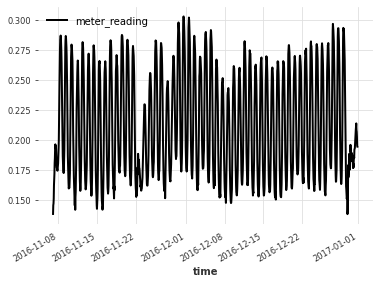

In [98]:
pred.plot()

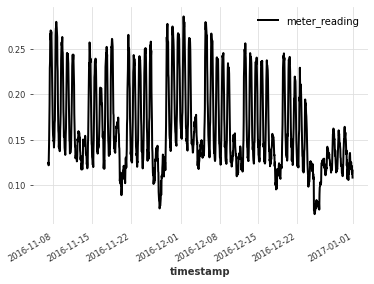

In [99]:
test_target.plot()

In [100]:
from darts.metrics.metrics import rmsle, smape

In [101]:
smape(test_target, pred)

29.881730115362544